# Feature Engineering

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

### Load Data

In [3]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = os.path.join(path, file)
data = pd.read_csv(csv_path)

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Apply cleaning and processing done in data preparation

In [5]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)
data.reset_index()

,index,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Data Overview

In [6]:
data.shape

(7032, 20)

In [7]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Strategies

#### Feature Engineering  strategies

There are a few strategies that we can try out in Feature Engineering. We will test a few base models with each of these to check the redundancy of certain features.
- The `PhoneService` might be redundant as the information is already captured in `MultipleLines`
- We will be using `One-Hot Encoding` to handle the categorical variables in the data. But some of the features (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`) contain the same value 'No Internet Service'. So while applying One-Hot Encoder this feature gets duplicated. We can therefore add a separate feature to show if the customer has 'No Internet Service' and set the value as 'No' in the other features.
- The `TotalCharges` feature is approximately equal to the product of `tenure` and `MonthlyCharges`. We can check how removing `TotalCharges` affects performance.

We can use LightGBM to select which feature engineering to proceed with.

#### Dataset Balancing Strategy

We have also seen that the dataset is imbalanced and that only around 25% of the data contains Churners. We can therefore try an over sampling and under-sampling using SMOTEEN

#### Classifier Model to select a feature engineering strategy

In [8]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

lgbm  = LGBMClassifier()
logreg  = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
xgb = XGBClassifier()
ada = AdaBoostClassifier()


In [9]:
# ROC AUC Plot
def roc_auc_plot(y_test, y_proba):


    plt.figure(figsize=(5, 5))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
        
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

In [10]:
# Basic One-Hot Encoding to test
X1 = data.drop('Churn', axis=1)
y1 = data['Churn'].replace({"Yes":1, "No":0})
X1_OH = pd.get_dummies(X1)
X1_train_temp, X1_test, y1_train_temp, y1_test = train_test_split(X1_OH, y1, test_size=0.2, random_state=1)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train_temp, y1_train_temp, test_size=0.25, random_state=1)

score: 0.8052594171997157

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1052
           1       0.63      0.54      0.58       355

    accuracy                           0.81      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407

[[942 110]
 [164 191]]


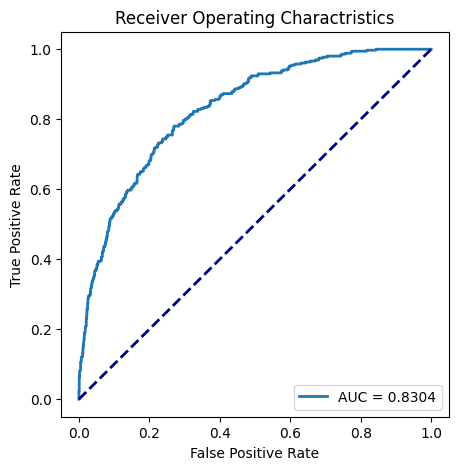

In [11]:
# LightGBM
lgbm.fit(X1_train, y1_train)

y1_pred = lgbm.predict(X1_val)
y1_proba = lgbm.predict_proba(X1_val)[:,1]

print("score: {}\n".format(lgbm.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.8088130774697939

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1052
           1       0.64      0.57      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[936 116]
 [153 202]]


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


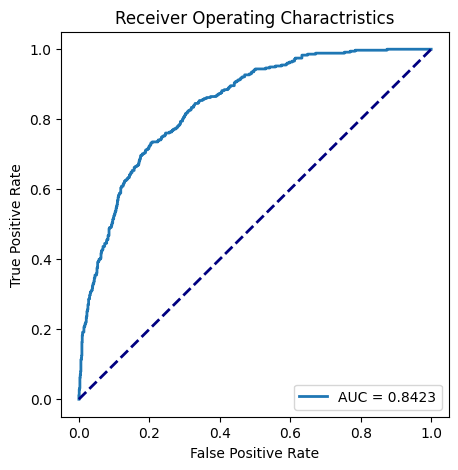

In [12]:
# LogisticRegression
logreg.fit(X1_train, y1_train)

y1_pred = logreg.predict(X1_val)
y1_proba = logreg.predict_proba(X1_val)[:,1]

print("score: {}\n".format(logreg.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.7931769722814499

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1052
           1       0.61      0.50      0.55       355

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407

[[938 114]
 [177 178]]


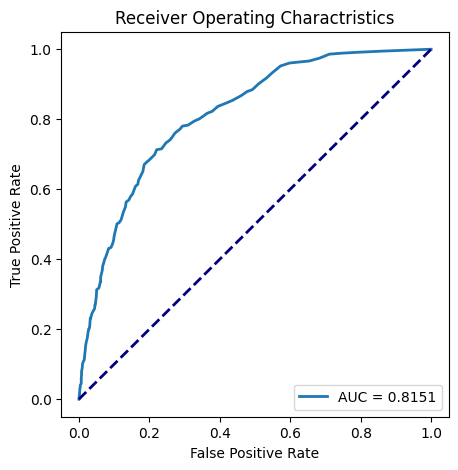

In [13]:
# RandomForestClassifer
rfc.fit(X1_train, y1_train)

y1_pred = rfc.predict(X1_val)
y1_proba = rfc.predict_proba(X1_val)[:,1]

print("score: {}\n".format(rfc.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.7455579246624022

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1052
           1       0.50      0.54      0.52       355

    accuracy                           0.75      1407
   macro avg       0.67      0.68      0.67      1407
weighted avg       0.75      0.75      0.75      1407

[[856 196]
 [162 193]]


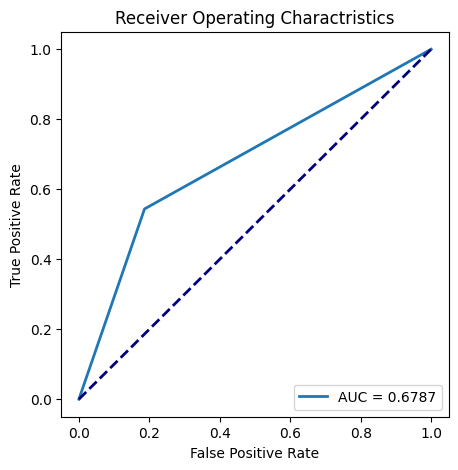

In [14]:
# DecisionTreeClasifier
dtc.fit(X1_train, y1_train)

y1_pred = dtc.predict(X1_val)
y1_proba = dtc.predict_proba(X1_val)[:,1]

print("score: {}\n".format(dtc.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.7917555081734187

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1052
           1       0.59      0.55      0.57       355

    accuracy                           0.79      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407

[[919 133]
 [160 195]]


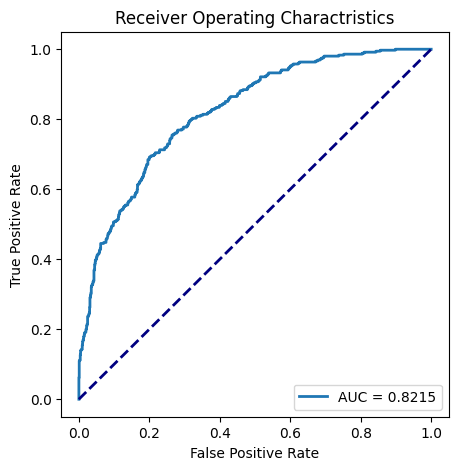

In [15]:
# XGBoost
xgb.fit(X1_train, y1_train)

y1_pred = xgb.predict(X1_val)
y1_proba = xgb.predict_proba(X1_val)[:,1]

print("score: {}\n".format(xgb.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.7967306325515281

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1052
           1       0.61      0.52      0.57       355

    accuracy                           0.80      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

[[935 117]
 [169 186]]


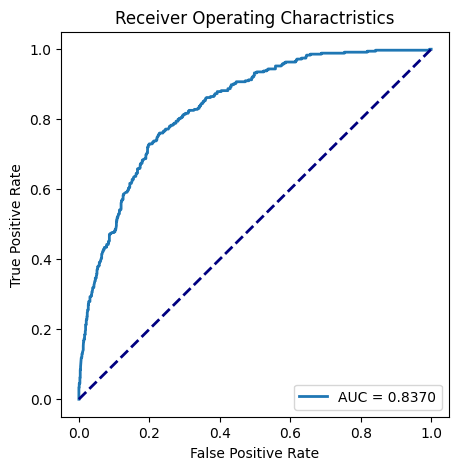

In [16]:
# AdaBoost
ada.fit(X1_train, y1_train)

y1_pred = ada.predict(X1_val)
y1_proba = ada.predict_proba(X1_val)[:,1]

print("score: {}\n".format(ada.score(X1_val, y1_val)))
print(classification_report(y1_val, y1_pred))
print(confusion_matrix(y1_val, y1_pred))
roc_auc_plot(y1_val, y1_proba)

score: 0.7967306325515281

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1041
           1       0.63      0.54      0.58       366

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

[[924 117]
 [169 197]]


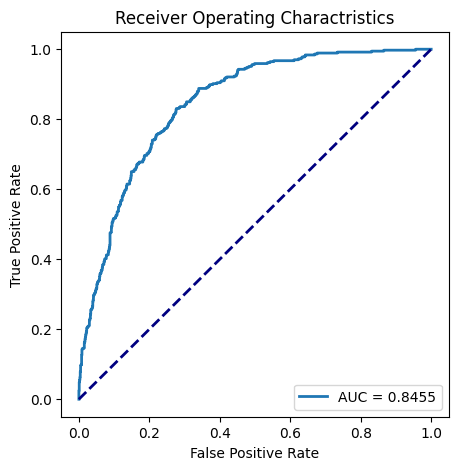

In [17]:
# Logistic Regressor on test
y1_pred = logreg.predict(X1_test)
y1_proba = logreg.predict_proba(X1_test)[:,1]

print("score: {}\n".format(logreg.score(X1_test, y1_test)))
print(classification_report(y1_test, y1_pred))
print(confusion_matrix(y1_test, y1_pred))
roc_auc_plot(y1_test, y1_proba)

We can select LogisticRegression as the base model to test different Feature Engineering techniques. Based on the above

Some of the newer models can handle categorical variables without encoding. We can try these as well.

#### Without Feature Enginnering

score: 0.7967306325515281

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1052
           1       0.61      0.52      0.56       355

    accuracy                           0.80      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

[[936 116]
 [170 185]]


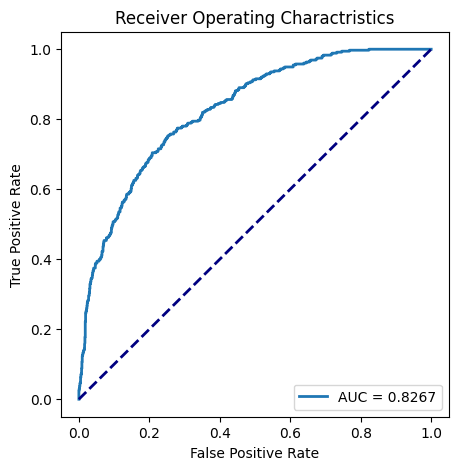

In [18]:
# This requires a model like LightGBM that can handle Categorical fetures as it is
classifier = LGBMClassifier()

X2 = data.drop('Churn', axis=1)
y2 = data['Churn'].replace({"Yes":1, "No":0})

cat_columns = X2.select_dtypes(include='object').columns.to_list()
num_columns = X2.select_dtypes(include='number').columns.to_list()

for column in cat_columns:
    X2[column] = X2[column].astype('category')

X2_train_temp, X2_test, y2_train_temp, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_temp, y2_train_temp, test_size=0.25, random_state=1)

classifier.fit(X2_train, y2_train)

y_pred = classifier.predict(X2_val)
y_proba = classifier.predict_proba(X2_val)[:,1]

print("score: {}\n".format(classifier.score(X2_val, y2_val)))
print(classification_report(y2_val, y_pred))
print(confusion_matrix(y2_val, y_pred))
roc_auc_plot(y2_val, y_proba)


As Logistic Regression gives the best AUC we can check the different Feature Engineering strategies using it.

### Feature Engineering

#### Base Train-Val-Test

In [19]:
X = data.drop('Churn', axis=1)
y = data['Churn'].replace({"Yes":1, "No":0})

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=1)

cat_columns = X.select_dtypes(include='object').columns.to_list()
num_columns = X.select_dtypes(include='number').columns.to_list()

#### FE-1 : One-Hot Encode Categroical features

In [20]:
transformer1 = [("OH", OneHotEncoder(sparse_output=False), cat_columns),
                ("passthrough", "passthrough", num_columns)]

preprocessor1 = ColumnTransformer(transformer1)

In [21]:
preprocessor1.fit(X_train)
X_train_fe1 = preprocessor1.transform(X_train)
X_val_fe1 = preprocessor1.transform(X_val)

feature_names_fe1 = []
for name, trans, column in preprocessor1.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names_fe1.extend(trans.get_feature_names_out(column))
    else:
        feature_names_fe1.extend(column)

X_train_fe1 = pd.DataFrame(X_train_fe1, columns=feature_names_fe1)
X_val_fe1 = pd.DataFrame(X_val_fe1, columns=feature_names_fe1)

score: 0.8109452736318408

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1052
           1       0.64      0.56      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[942 110]
 [156 199]]


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


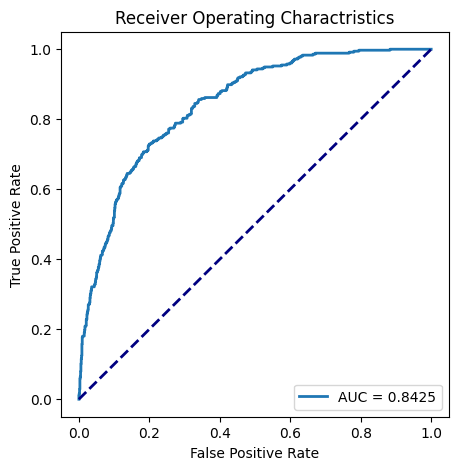

In [22]:
logreg.fit(X_train_fe1, y_train)

y_pred_fe1 = logreg.predict(X_val_fe1)
y_proba_fe1 = logreg.predict_proba(X_val_fe1)[:,1]

print("score: {}\n".format(logreg.score(X_val_fe1, y_val)))
print(classification_report(y_val, y_pred_fe1))
print(confusion_matrix(y_val, y_pred_fe1))
roc_auc_plot(y_val, y_proba_fe1)

#### FE-2 : One-Hot Encode Categroical features and scale numerical features

In [23]:
transformer2 = [("OH", OneHotEncoder(sparse_output=False), cat_columns),
                ("scaler", MinMaxScaler(), num_columns)]

preprocessor2 = ColumnTransformer(transformer2)

In [24]:
preprocessor1.fit(X_train)
X_train_fe2 = preprocessor1.transform(X_train)
X_val_fe2 = preprocessor1.transform(X_val)

feature_names_fe2 = []
for name, trans, column in preprocessor1.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names_fe2.extend(trans.get_feature_names_out(column))
    else:
        feature_names_fe2.extend(column)

X_train_fe2 = pd.DataFrame(X_train_fe2, columns=feature_names_fe2)
X_val_fe2 = pd.DataFrame(X_val_fe2, columns=feature_names_fe2)

score: 0.8109452736318408

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1052
           1       0.64      0.56      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[942 110]
 [156 199]]


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


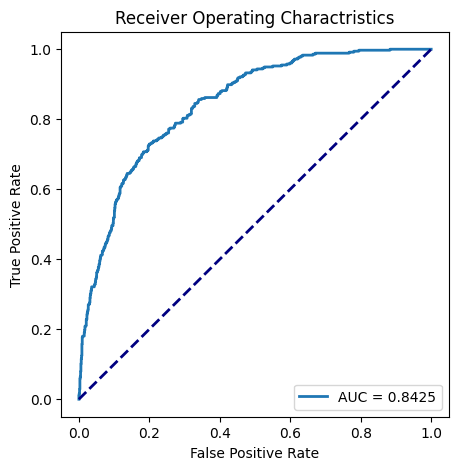

In [25]:
logreg.fit(X_train_fe2, y_train)

y_pred_fe2 = logreg.predict(X_val_fe2)
y_proba_fe2 = logreg.predict_proba(X_val_fe2)[:,1]

print("score: {}\n".format(logreg.score(X_val_fe2, y_val)))
print(classification_report(y_val, y_pred_fe2))
print(confusion_matrix(y_val, y_pred_fe2))
roc_auc_plot(y_val, y_proba_fe2)

#### FE-3 : One-Hot Encode Categroical features and remove redundant features

In [26]:
internet_addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

X_train_fe3 = X_train.drop('PhoneService', axis=1).copy()
X_val_fe3 = X_val.drop('PhoneService', axis=1).copy()
X_test_fe3 = X_test.drop('PhoneService', axis=1).copy()

for col in internet_addon_services:
    if col in X_train_fe3.columns:
        X_train_fe3[col] = X_train_fe3[col].replace({'No internet service':'No'})
        X_val_fe3[col] = X_val_fe3[col].replace({'No internet service':'No'})
        X_test_fe3[col] = X_test_fe3[col].replace({'No internet service':'No'})

cat_columns1 = X_train_fe3.columns[(X_train_fe3 == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
cat_columns2 = list(set(X_train_fe3.select_dtypes(include='object').columns)-set(cat_columns1))  # We can drop the first column for these features

In [27]:
drop_no = ['No'] * len(cat_columns1)

transformer3 = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns), # Scale Numerical columns to lie between 0 and 1
                #('passthrough', 'passthrough', num_columns)
                ]

preprocessor3 = ColumnTransformer(transformer3)

In [28]:
X_train_fe3 = preprocessor3.fit_transform(X_train_fe3)
X_val_fe3 = preprocessor3.transform(X_val_fe3)

feature_names = []
for name, trans, column in preprocessor3.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_train_fe3 = pd.DataFrame(X_train_fe3, columns=feature_names)
X_val_fe3 = pd.DataFrame(X_val_fe3, columns=feature_names)

score: 0.8102345415778252

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1052
           1       0.64      0.56      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[942 110]
 [157 198]]


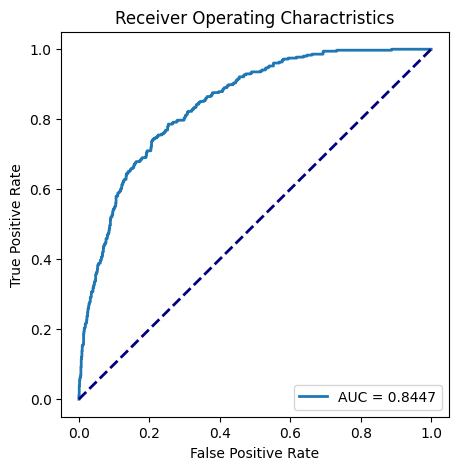

In [29]:
logreg.fit(X_train_fe3, y_train)

y_pred_fe3 = logreg.predict(X_val_fe3)
y_proba_fe3 = logreg.predict_proba(X_val_fe3)[:,1]

print("score: {}\n".format(logreg.score(X_val_fe3, y_val)))
print(classification_report(y_val, y_pred_fe3))
print(confusion_matrix(y_val, y_pred_fe3))
roc_auc_plot(y_val, y_proba_fe3)

Using scaler for numerical columns helped with convergence and in improving AUC. Removing `PhoneService` did not increase or decrease the performance, so we will keep it removed.

#### FE-4 : Removing `TotalCharges`

In [30]:
internet_addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

X_train_fe4 = X_train.drop(['PhoneService', 'TotalCharges'], axis=1).copy()
X_val_fe4 = X_val.drop(['PhoneService', 'TotalCharges'], axis=1).copy()
X_test_fe4 = X_test.drop(['PhoneService', 'TotalCharges'], axis=1).copy()

for col in internet_addon_services:
    if col in X_train_fe4.columns:
        X_train_fe4[col] = X_train_fe4[col].replace({'No internet service':'No'})
        X_val_fe4[col] = X_val_fe4[col].replace({'No internet service':'No'})
        X_test_fe4[col] = X_test_fe4[col].replace({'No internet service':'No'})

cat_columns1 = X_train_fe4.columns[(X_train_fe4 == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
cat_columns2 = list(set(X_train_fe4.select_dtypes(include='object').columns)-set(cat_columns1))  # We can drop the first column for these features
num_columns1 = X_train_fe4.select_dtypes(include='number').columns.to_list()

In [31]:
drop_no = ['No'] * len(cat_columns1)

transformer4 = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns1), # Scale Numerical columns to lie between 0 and 1
                #('passthrough', 'passthrough', num_columns1)
                ]

preprocessor4 = ColumnTransformer(transformer4)

In [32]:
X_train_fe4 = preprocessor4.fit_transform(X_train_fe4)
X_val_fe4 = preprocessor4.transform(X_val_fe4)

feature_names = []
for name, trans, column in preprocessor4.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_train_fe4 = pd.DataFrame(X_train_fe4, columns=feature_names)
X_val_fe4 = pd.DataFrame(X_val_fe4, columns=feature_names)

score: 0.8116560056858564

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1052
           1       0.65      0.56      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[944 108]
 [157 198]]


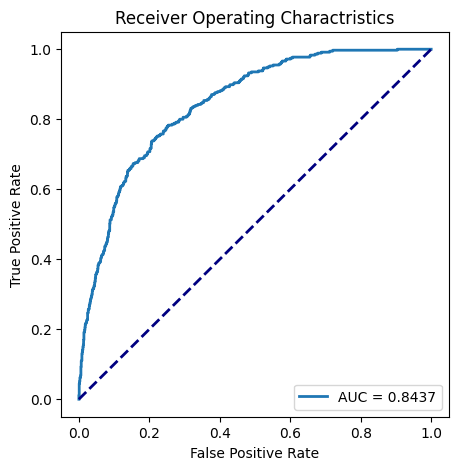

In [33]:
logreg.fit(X_train_fe4, y_train)

y_pred_fe4 = logreg.predict(X_val_fe4)
y_proba_fe4 = logreg.predict_proba(X_val_fe4)[:,1]

print("score: {}\n".format(logreg.score(X_val_fe4, y_val)))
print(classification_report(y_val, y_pred_fe4))
print(confusion_matrix(y_val, y_pred_fe4))
roc_auc_plot(y_val, y_proba_fe4)

### Feature Engineering summary

Based on the AUC scores we can select Feature Engineering 3 as optimal

- We perform One Hot Encoding on Categorical Features
- We remove redundant features
- We scale numerical features

Athough the performance improvement is minor. It helps us convert all categorical features to numeric, ensuring it works with all models. It also keeps the features to a minimum while capturing relevant information. The sclaer also helps the model converge.

score: 0.7953091684434968

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1041
           1       0.62      0.54      0.58       366

    accuracy                           0.80      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

[[923 118]
 [170 196]]


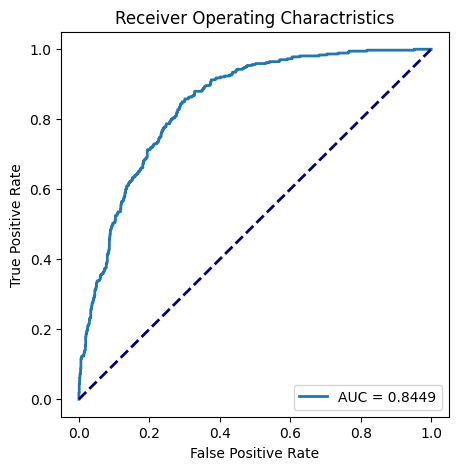

In [34]:
X_test_fe3 = preprocessor3.transform(X_test_fe3)

feature_names = []
for name, trans, column in preprocessor3.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_test_fe3 = pd.DataFrame(X_test_fe3, columns=feature_names)

logreg.fit(X_train_fe3, y_train)

y_pred_fe3 = logreg.predict(X_test_fe3)
y_proba_fe3 = logreg.predict_proba(X_test_fe3)[:,1]

print("score: {}\n".format(logreg.score(X_test_fe3, y_test)))
print(classification_report(y_test, y_pred_fe3))
print(confusion_matrix(y_test, y_pred_fe3))
roc_auc_plot(y_test, y_proba_fe3)

### Dataset Balancing

Since dataset is imbalanced we can perform oversampling and test performance.

We can try 3 different over sampling techniques `SMOTE`, `ADASYN` and `SMOTEENN`

In [35]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

#### Previously selected Feature Engineering

In [51]:
X = data.drop(['Churn', 'PhoneService'], axis=1)
y = data['Churn'].replace({"Yes":1, "No":0})

internet_addon_services = X.columns[(X == 'No internet service').any()].to_list()
for col in internet_addon_services:
    X[col] = X[col].replace({'No internet service':'No'})

cat_columns = X.select_dtypes(include='object').columns.to_list()
num_columns = X.select_dtypes(include='number').columns.to_list()

cat_columns1 = X.columns[(X == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
cat_columns2 = list(set(X.select_dtypes(include='object').columns)-set(cat_columns1))  # We can drop the first column for these features

# Train - Validation - Test Split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=1)

drop_no = ['No'] * len(cat_columns1)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns), # Scale Numerical columns to lie between 0 and 1
                ]

preprocessor = ColumnTransformer(transformer)

X_train_ppd = preprocessor.fit_transform(X_train)
X_val_ppd = preprocessor.transform(X_val)
X_test_ppd = preprocessor.transform(X_test)

feature_names = []
for name, trans, column in preprocessor.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_train_ppd = pd.DataFrame(X_train_ppd, columns=feature_names)
X_val_ppd = pd.DataFrame(X_val_ppd, columns=feature_names)
X_test_ppd = pd.DataFrame(X_test_ppd, columns=feature_names)

score: 0.8102345415778252

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1052
           1       0.64      0.56      0.60       355

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407

[[942 110]
 [157 198]]


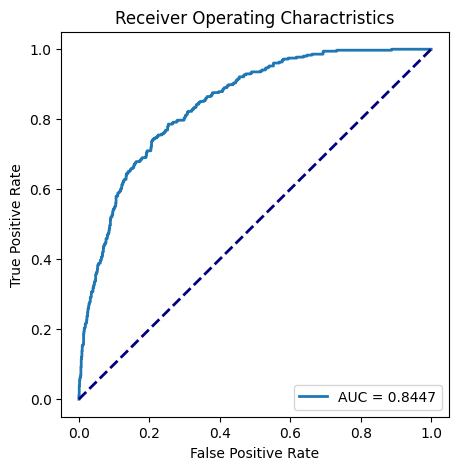

In [57]:
logreg_bal = LogisticRegression()
logreg_bal.fit(X_train_ppd, y_train)

y_pred_ppd = logreg_bal.predict(X_val_ppd)
y_proba_ppd = logreg_bal.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg_bal.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred_ppd))
print(confusion_matrix(y_val, y_pred_ppd))
roc_auc_plot(y_val, y_proba_ppd)

#### SMOTE

In [38]:
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ppd, y_train)

In [39]:
X_train_ppd.shape, X_train_smote.shape

((4218, 23), (6140, 23))

score: 0.8081023454157783

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.75      0.74      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[918 134]
 [136 219]]


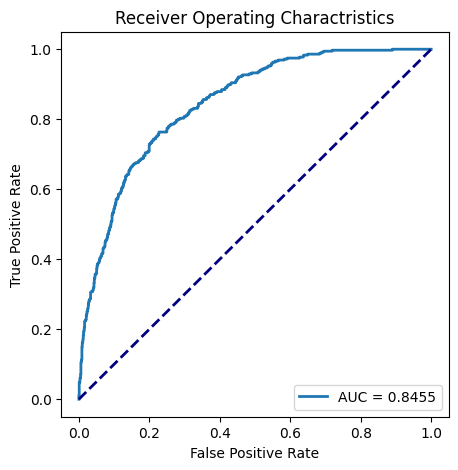

In [55]:
logreg.fit(X_train_smote, y_train_smote)

y_pred = logreg.predict(X_val_ppd)
y_proba = logreg.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
roc_auc_plot(y_val, y_proba)

#### ADASYN

In [41]:
adasyn = ADASYN(random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_ppd, y_train)

In [42]:
X_train_ppd.shape, X_train_adasyn.shape

((4218, 23), (6094, 23))

score: 0.7356076759061834

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1052
           1       0.49      0.80      0.61       355

    accuracy                           0.74      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.81      0.74      0.75      1407

[[750 302]
 [ 70 285]]


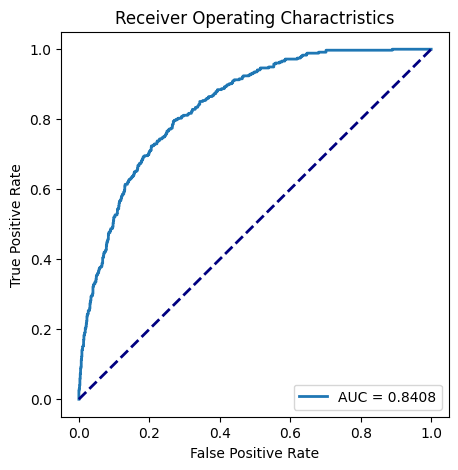

In [43]:
logreg.fit(X_train_adasyn, y_train_adasyn)

y_pred = logreg.predict(X_val_ppd)
y_proba = logreg.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
roc_auc_plot(y_val, y_proba)

#### SMOTEENN

In [44]:
smoteenn = SMOTEENN(random_state=1)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_ppd, y_train)

In [45]:
X_train_ppd.shape, X_train_smoteenn.shape

((4218, 23), (3734, 23))

score: 0.6986496090973703

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1052
           1       0.45      0.85      0.59       355

    accuracy                           0.70      1407
   macro avg       0.69      0.75      0.67      1407
weighted avg       0.81      0.70      0.72      1407

[[682 370]
 [ 54 301]]


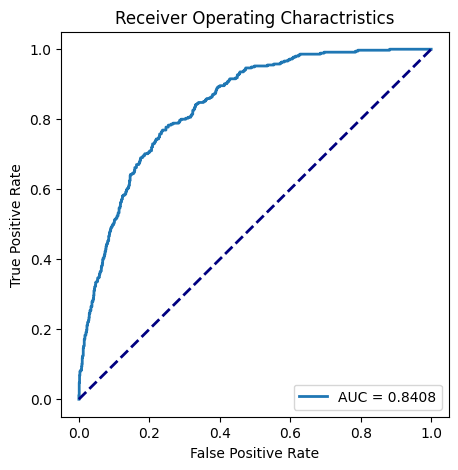

In [46]:
logreg.fit(X_train_smoteenn, y_train_smoteenn)

y_pred = logreg.predict(X_val_ppd)
y_proba = logreg.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
roc_auc_plot(y_val, y_proba)

Among these we observed better performance with `SMOTE`. The AUC score for each dataset balancing techniques was lower than that for the imbalanced datset. For each we managed to improve the True Positives and thereby the Recall and F1-Score but at the cost of a high number of False Positives. Both `ADASYN` and `SMOTEENN` predicts more False positives than True Positives.

#### SMOTE optimization

In [47]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [48]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('SMOTE', smote), ('Logistic Regression', logreg)])

param_grid = {
    'SMOTE__k_neighbors': [5, 6, 7],
    'SMOTE__sampling_strategy': [0.45, 0.5, 0.55],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train_ppd, y_train)

print("Best Parameters : ", grid_search.best_params_)

Best Parameters :  {'SMOTE__k_neighbors': 6, 'SMOTE__sampling_strategy': 0.55}


score: 0.6986496090973703

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1052
           1       0.59      0.65      0.62       355

    accuracy                           0.80      1407
   macro avg       0.73      0.75      0.74      1407
weighted avg       0.81      0.80      0.80      1407

[[890 162]
 [123 232]]


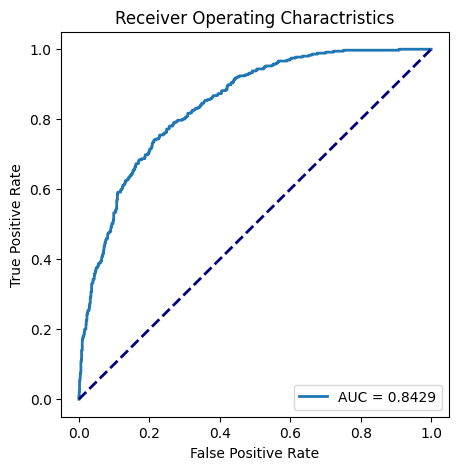

In [49]:
y_pred = grid_search.predict(X_val_ppd)
y_proba = grid_search.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
roc_auc_plot(y_val, y_proba)

score: 0.8081023454157783

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.75      0.74      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[918 134]
 [136 219]]


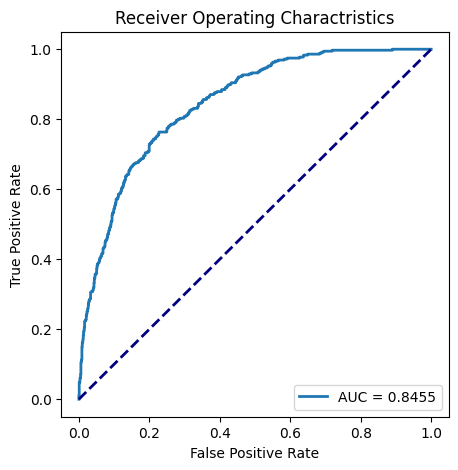

In [50]:
smote = SMOTE(k_neighbors=7, sampling_strategy=0.45, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ppd, y_train)
logreg.fit(X_train_smote, y_train_smote)

y_pred = logreg.predict(X_val_ppd)
y_proba = logreg.predict_proba(X_val_ppd)[:,1]

print("score: {}\n".format(logreg.score(X_val_ppd, y_val)))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
roc_auc_plot(y_val, y_proba)

### Conclusion

We can proceed to model selection with the feature engineering as described above and using `SMOTE` for oversampling.